In [4]:
cd /home

/home


# Results experiments

###### by Cristobal Donoso-Oliva et.al., 2022

In [5]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import pandas as pd
import numpy as np
import tomli
import os 

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [6]:
def collect_metrics(config_files_folder, classification=False):
    '''
    Concatenate dataframes containing testing/validation metrics.
    It assumes a fixed structure:
    '<path of the experiments>/<science_case>/config_file.toml'
    '''
    metrics_list = []
    for sci_case in ['a', 'b']:
        config_files = f'{config_files_folder}/{sci_case}/'
        for file in os.listdir(config_files):
            sample_per_class = file.split('_')[0]
            fold_n = file.split('_')[-1].split('.')[0]
            
            current = os.path.join(config_files, file)
            with open(current, mode="rb") as fp:
                config = tomli.load(fp)
            
            if classification:
                metrics = pd.read_csv(os.path.join(config['classification']['exp_path'], 'metrics.csv'))
                metrics['model'] = ['mlp_att', 'lstm_att', 'lstm']
                metrics['fold'] = [fold_n]*metrics.shape[0]
                metrics['spc']  = [sample_per_class]*metrics.shape[0]
                metrics['case']  = [sci_case]*metrics.shape[0]
                metrics_list.append(metrics)
            else:
                metrics = pd.read_csv(os.path.join(config['finetuning']['exp_path'], 'metrics.csv'))
                metrics['fold'] = [fold_n]*metrics.shape[0]
                metrics['spc']  = [sample_per_class]*metrics.shape[0]
                metrics['case']  = [sci_case]*metrics.shape[0]
                metrics_list.append(metrics)
            

    return pd.concat(metrics_list)

Use `collect_metrics` to join all the metrics associated with the experiments in 
`./presentation/pipeline/config/<experiment>`

By default it gives **finetuning** metrics. Use `clasification=True` for getting classification metrics 

In [12]:
experiments_config_files = './presentation/pipeline/config/alcock'

metrics_ft = collect_metrics(experiments_config_files)

In [16]:
metrics_ft.groupby('case').mean()

,rmse,r_square
case,,
a,0.111146,0.787404
b,0.108896,0.797648


# Metrics by number of samples per class

Defining plot styles for the classifiers

In [8]:
styles = {'MLP+ATT':{'marker':'^', 'linestyle':'--'}, 
          'LSTM+ATT':{'marker':'o', 'linestyle':'-'}, 
          'Baseline':{'marker':'s', 'linestyle':':'}}

In [9]:
selected_metric = 'acc'

Text(0.51, -0.02, 'Samples per class')

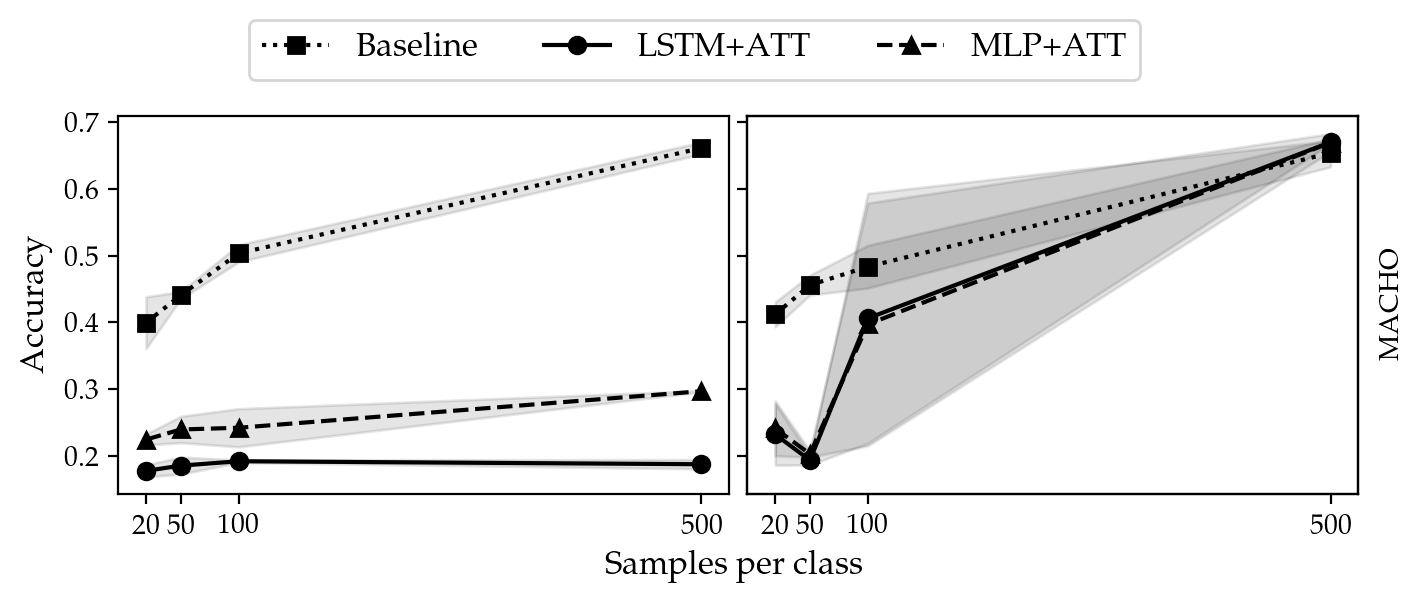

In [11]:
fig, axes = plt.subplots(1,2, figsize=(8,2.5), 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.03},
                         sharey=True, dpi=200)

for row, dataset_name in enumerate(['alcock']):
    experiments_config_files = './presentation/pipeline/config/{}'.format(dataset_name)
    metrics = collect_metrics(experiments_config_files, classification=True)
    metrics = metrics.replace({'mlp_att':'MLP+ATT', 'lstm_att':'LSTM+ATT', 'lstm':'Baseline'})


    metrics_by_case = metrics.groupby('case')
    for col, (sci_case, frame_0) in enumerate(metrics_by_case):
        metrics_by_model = frame_0.groupby('model')

        for model_name, frame_1 in metrics_by_model:
            metrics_by_spc = frame_1.groupby('spc')

            model_metrics = []
            for spc, frame_2 in metrics_by_spc:
                mean = frame_2[selected_metric].astype(float).mean()
                std = frame_2[selected_metric].astype(float).std()
                model_metrics.append((float(spc), mean, std))

            sorted_metrics = sorted(model_metrics, key=lambda tup: tup[0])
            sorted_metrics = np.vstack(sorted_metrics)
            axes[col].plot(sorted_metrics[:, 0], 
                             sorted_metrics[:, 1], 
                             marker=styles[model_name]['marker'], 
                             color='k',
                             linestyle=styles[model_name]['linestyle'],
                             label=model_name)
            axes[col].fill_between(sorted_metrics[:, 0], 
                                     sorted_metrics[:, 1]+sorted_metrics[:, 2], 
                                     sorted_metrics[:, 1]-sorted_metrics[:, 2],
                                     color='k', alpha=0.1)

            axes[col].set_xticks(sorted_metrics[:, 0])
    #         axes[index].set_xscale('log')


        if col == 1:
            ax2 = axes[col].twinx()     
            ax2.set_yticks([])
            ax2.set_ylabel('MACHO')

    
axes[0].legend(ncol=3, bbox_to_anchor = (1.7, 1.3), fontsize=12)
if selected_metric == 'acc':
    axes[0].set_ylabel('Accuracy', fontsize=12)


fig.text(0.51, -0.02, 'Samples per class', ha='center', va='center', fontsize=12)